**Chapter 7 – Ensemble Learning and Random Forests**

_This notebook contains all the sample code and solutions to the exercices in chapter 7._

A group of predictors is called an emsemble. emsemble model can give better answer: wisdom of the crowd.

most popular Ensemble methods:
* bagging
* boosting
* stacking

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [80]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

# Voting classifiers

* hard voting: majority-vote
* soft voting: average highest class probability of all individual classifier .

In [81]:
# 10 tossers
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

Saving figure law_of_large_numbers_plot


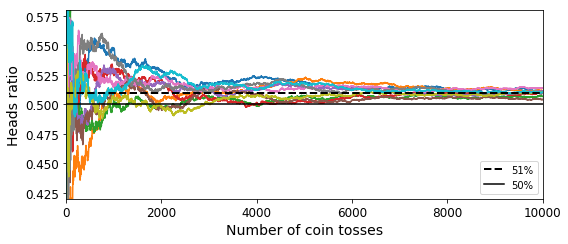

In [3]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
# default ratio: 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [18]:
train_test_split?

In [14]:
# hard voting
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[(u'lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), (u'rf', RandomF...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting=u'hard', weights=None)

In [11]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))
    
# the voting_clf outperforms all the individual classsifier

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


In [15]:
# let's try soft voting
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)  # use probability

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[(u'lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), (u'rf', RandomF...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting=u'soft', weights=None)

In [16]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))
    
# better!

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


# Bagging ensembles

another aproach is to use same training algrithm for every predictor, but different random subset of training dta.

In [28]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# bagging with 500 trees
# bootstra=False for pasting method
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [29]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [21]:
# use one DecisionTree only
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [79]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


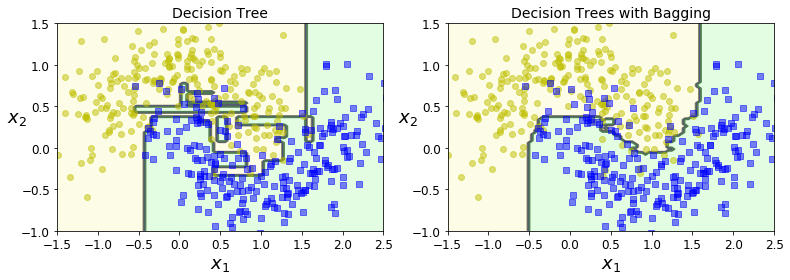

In [27]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

# Random Forests

## random pathes method: 
sampling both training instances and features

## random forest:
an ensemble of DT, generally trained via the bagging(pasting) method, typically with max_samples set to the size of the training set.

In [30]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

In [31]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [32]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [33]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions

0.97599999999999998

In [34]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.112492250999
sepal width (cm) 0.0231192882825
petal length (cm) 0.441030464364
petal width (cm) 0.423357996355


In [35]:
# Random Forest can give a quick understanding of feature importances, 
# in perticular you need to perform feature selection. 
rnd_clf.feature_importances_

array([ 0.11249225,  0.02311929,  0.44103046,  0.423358  ])

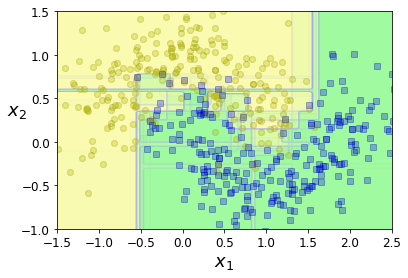

In [37]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()

## Out-of-Bag evaluation

In [38]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_
#bag_clf.oob_decision_function_

0.90133333333333332

In [39]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.91200000000000003

## Feature importance

In [40]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [41]:
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [42]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


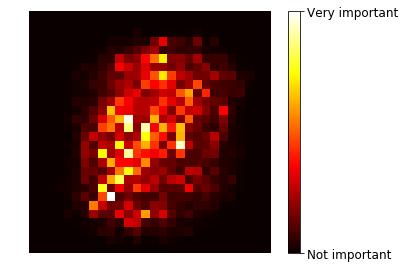

In [43]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

# Boosting
the general idea of boosting is train predictors sequentially, each trying to correct its predecessor.

poplular boosting methods:

* AdaBoost: tweek importanc weights at each iteration.
* Grading Boosting: fit the new predictor to the residual errors made by previous predictor. for prediction, simply add up all.

# AdaBoost

In [209]:
# implement AdaBoost classification ,TBD: score weired with n_estimators and max_depth

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [219]:
# initial

eta = 0.5 # learning_rate
n_estimators = 20 # simple start
max_depth = 1
Clf = DecisionTreeClassifier
W = np.ones((X_train.shape[0])) / X_train.shape[0]    # instance weight

# build_trees
clfs, Alpha = [], []
for j in range(n_estimators):
    clfs.append(Clf(max_depth=max_depth))
    clf = clfs[j]
    clf.fit(X_train, y_train, sample_weight=W)
    incorrect = clf.predict(X_train) != y_train
    # Equation7-1, error rate of predictors
    r = np.mean(np.average(incorrect, weights=W, axis=0))
    # Stop if classification is perfect   
    print(r)
    if r <= 0:
        break
    # 7-2 predictor weight
    Alpha.append(eta * np.log((1 - r) / r + np.log(len(clfs)-1)))
    # 7-3, update Weight
    W[incorrect] *= np.exp(Alpha[j])
    # normalize
    #W /= W.sum()

# predict
K = np.zeros((y_test.shape[0], n_estimators), dtype=np.int32)
for j in range(n_estimators):
    K[:,j] = clfs[j].predict(X_test)
# find max k with sum(alpha)
V = np.zeros((y_test.shape[0], 2))
for i in range(y_test.shape[0]):
    for j in range(n_estimators):
        if K[i,j] == y_test[i]:
            V[i,y_test[i]] += Alpha[j]

y_pred = np.argmax(V, axis=1)
print('clfs len: %s' % len(clfs))
print(accuracy_score(y_test, y_pred))

0.181333333333
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
clfs len: 20
0.912


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log


In [83]:
from sklearn.ensemble import AdaBoostClassifier
# SAMME is a multiclass method,  SAMME16 (which stands for Stagewise Additive Modeling using a 
# Multiclass Exponential loss function). 
# Scikit-Learn can use a variant of SAMME called SAMME.R (the R stands for “Real”), which relies 
# on class probabilities(soft voting) rather than predictions and generally performs better.


ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm=u'SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

In [84]:
y_pred = ada_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.944


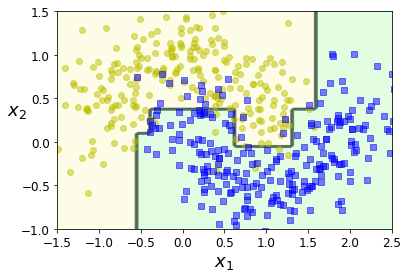

In [85]:
plot_decision_boundary(ada_clf, X, y)

Saving figure boosting_plot


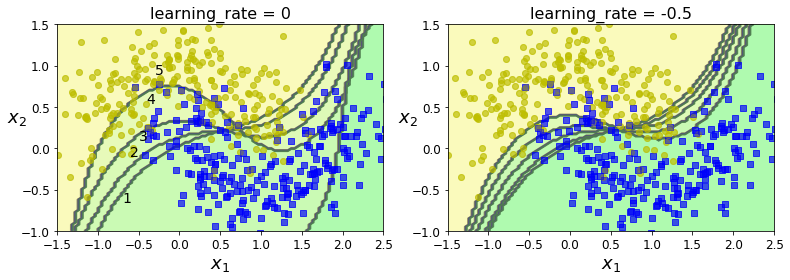

In [46]:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    for i in range(5):
        plt.subplot(subplot)
        svm_clf = SVC(kernel="rbf", C=0.05, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate - 1), fontsize=16)

plt.subplot(121)
plt.text(-0.7, -0.65, "1", fontsize=14)
plt.text(-0.6, -0.10, "2", fontsize=14)
plt.text(-0.5,  0.10, "3", fontsize=14)
plt.text(-0.4,  0.55, "4", fontsize=14)
plt.text(-0.3,  0.90, "5", fontsize=14)
save_fig("boosting_plot")
plt.show()

In [47]:
list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))

['base_estimator_',
 'classes_',
 'estimator_errors_',
 'estimator_weights_',
 'estimators_',
 'feature_importances_',
 'n_classes_']

# Gradient Boosting

In [48]:
# implement Gradient Boosting trees
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [49]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [50]:
# train 2nd DT
# residual errors
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [51]:
# train 3rd DT
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [52]:
X_new = np.array([[0.8]])

In [53]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [54]:
y_pred

array([ 0.75026781])

Saving figure gradient_boosting_plot


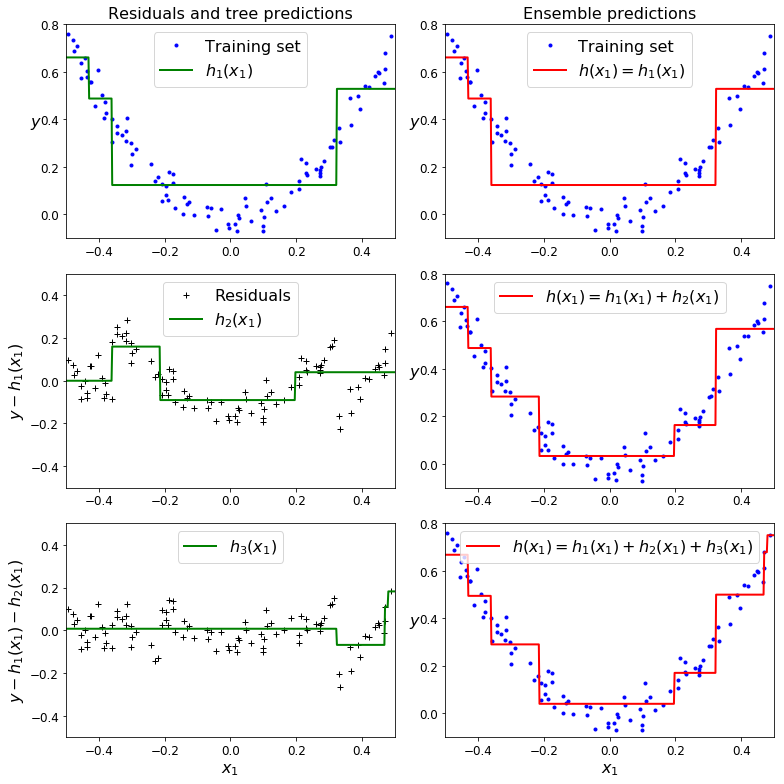

In [55]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

In [60]:
# use sklearn's method
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)
# use learning_rate to regularize, along with more trees
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

Saving figure gbrt_learning_rate_plot


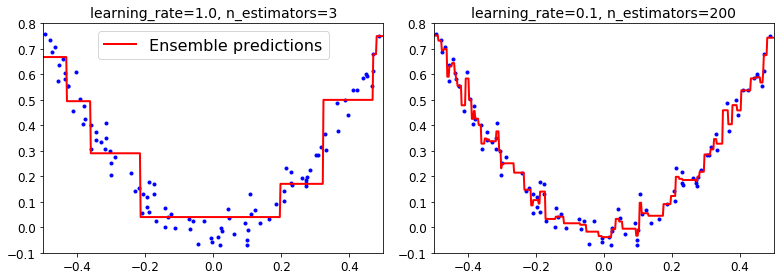

In [59]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

save_fig("gbrt_learning_rate_plot")
plt.show()

## Gradient Boosting with Early stopping

In [61]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=55, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [78]:
# sequential estimators, so the index is also num of estimator
errors[bst_n_estimators-5: bst_n_estimators+5]

[0.0027370024701472489,
 0.0027205012064232207,
 0.0027176421276560465,
 0.0027195073111332528,
 0.00272625716783103,
 0.002712853325235463,
 0.002719454272122578,
 0.0027133799581649065,
 0.0027221277186536084,
 0.0027136110678215226]

In [68]:
min_error = np.min(errors)

Saving figure early_stopping_gbrt_plot


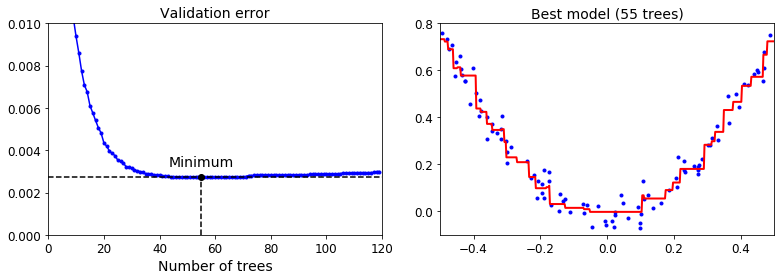

In [69]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

save_fig("early_stopping_gbrt_plot")
plt.show()

In [75]:
# warm_start to maintain state when fix an predict
# it seems simple to write a early stop method
# If subsample < 1.0 ,this results in Stochastic Gradient Boosting(SGD), quite easy

gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, subsample=0.25, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [76]:
print(gbrt.n_estimators)

70


# Stacking

Idea: instead of using trivial functions(such as hard voting) to aggregate the predictions, why dont't we train a model to perform the aggregation(blending)?

To train a blender, a common approach is to use a hold-out set.

* First, the training set is split in two subsets. The first subset is used to train the predictors in the first layer (see Figure 7-13).
* Next, the first layer predictors are used to make predictions on the second (held-out) set (see Figure 7-14). 
* We can create a new training set using these predicted values as input features (which makes this new training set three-dimensional), and keeping the target values.

* It is actually possible to train several different blenders this way. The trick is to split the training set into three subsets and train each layer with different data.

https://github.com/viisar/brew

In [150]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
# default ratio: 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.4, random_state=42)


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

# level1
for clf in (log_clf, rnd_clf, svm_clf):
    clf.fit(X_train1, y_train1)

def level2_data(X_):
    X3d=[]
    for clf in (log_clf, rnd_clf, svm_clf):
        X3d.append(clf.predict(X_))
    return np.column_stack(X3d)

# level2
clf2 = RandomForestClassifier(random_state=42)
clf2.fit(level2_data(X_train2), y_train2)
y_pred = clf2.predict(level2_data(X_test))
print(clf2.feature_importances_)
print(accuracy_score(y_test, y_pred))

# level1 score
for clf in (log_clf, rnd_clf, svm_clf):
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))    

[ 0.21078035  0.38595265  0.403267  ]
0.912
LogisticRegression 0.848
RandomForestClassifier 0.912
SVC 0.864


# Exercise solutions